# Определение стоимости автомобилей

В нашем распоряжении исторические данные сервиса по продаже автомобилей с пробегом: технические характеристики, комплектации и цены автомобилей.  
Сервис разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.  

Наша задача построить модель, для определения стоимости автомобиля, учитывая следующие критерии:
- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
# устанавливаем библиотеки
!pip install lightgbm

In [2]:
# импортируем библиотеки
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

## Подготовка данных

### Обзор данных

**Откроим файл с данными, изучим общую информацию.**

In [3]:
pth1 = '/datasets/autos.csv'
pth2 = 'https://restricted/datasets/autos.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
#elif os.path.exists(pth2):
#    data = pd.read_csv(pth2)
else:
    try:
        data = pd.read_csv(pth2)
    except:
        print('Something is wrong, datasets not found!!!')

In [4]:
# Выведем общую инф о df
def df_info(df):
    display(df.head())
    display(df.info())
    display(df.describe())
    print("Количество дубликатов:", df.duplicated().sum())

def nan_info(df):
    zero_val = (df == 0).astype(int).sum(axis=0)
    zero_val_percent =  round(zero_val / len(df) * 100, 2)
    mis_val = df.isnull().sum()
    mis_val_percent = round(mis_val / len(df) * 100, 2)
    
    info_table = pd.concat([zero_val, zero_val_percent, mis_val, mis_val_percent], axis=1)
    info_table = info_table.rename(
            columns={0: 'Нулевые значения', 1: '% значений', 2: 'Кол-во пропусков', 3: '% пропусков'})
    display(info_table)
    print("Данные представлены в", df.shape[1], "столбцах и", df.shape[0], "строках")
    print("В", info_table[info_table.iloc[:, 2] != 0].shape[0], "столбцах имеются пропуски в кол-ве", mis_val.sum(), "или " + str(round(mis_val.sum() / len(df) * 100, 2)) + "%")
   

In [5]:
df_info(data)
nan_info(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество дубликатов: 4


,Нулевые значения,% значений,Кол-во пропусков,% пропусков
DateCrawled,0,0.00,0,0.00
Price,10772,3.04,0,0.00
VehicleType,0,0.00,37490,10.58
RegistrationYear,0,0.00,0,0.00
Gearbox,0,0.00,19833,5.60
Power,40225,11.35,0,0.00
Model,0,0.00,19705,5.56
Kilometer,0,0.00,0,0.00
RegistrationMonth,37352,10.54,0,0.00
FuelType,0,0.00,32895,9.28


Данные представлены в 16 столбцах и 354369 строках
В 5 столбцах имеются пропуски в кол-ве 181077 или 51.1%


Данные представлены следующими признаками

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя  

**Целевой признак**
- `Price` — цена (евро)

В данных присутствуют пропуски, нулевые значения и аномалии - требуется предобработка данных.

## Предобработка данных

### Дубликаты

В данных присутствуют явные дубликаты, удалим их

In [6]:
data = data.drop_duplicates().reset_index(drop=True)

### Пропуски

В столбце `Model` — модель автомобиля, достоверно узнать модель авто не представляется, удалим эти данные

In [7]:
data.dropna(subset=['Model'], inplace=True)

В столбце `VehicleType` — тип автомобильного кузова, присутствуют пропуски (более 10%). Так как достоверно узнать тип кузова невозможно заменим на 'unknown'

In [8]:
data.VehicleType = data.VehicleType.fillna('unknown')

В столбце `Gearbox` — тип коробки передач и `FuelType` — тип топлива, пропуски заменим наиболее часто встречаемым для пары `Brand` - `Model`

In [9]:
def fill_with_mode(col):
    data[col] = data.groupby(['Brand', 'Model'])[col].apply( lambda x: x.fillna(x.mode()[0]))

In [10]:
fill_with_mode('Gearbox')
fill_with_mode('FuelType')

Пропуски в столбце `Repaired` — была машина в ремонте или нет, заполним исходя из того что отсутствие данных свидетельствует о том, что пользователь явно не указывал о ремонте машины т.к. его (ремонта) не было. Возможен технический сбой 

In [11]:
data.Repaired = data.Repaired.fillna('no')

### Аномалии

К явным выбросам отнесем следующее:
- В `Price` — цена, наблюдается необчно низкая (нулевая) и достаточно высокая стоимость авто;
- В `Power` — мощность (л.с.), наблюдается необчно низкая (нулевая) и достаточно высокая мощность;
- В `RegistrationYear` — год регистрации автомобиля, смущает минимальное значение (1000) и максимальное (9999).

Посмотрим на `Price`

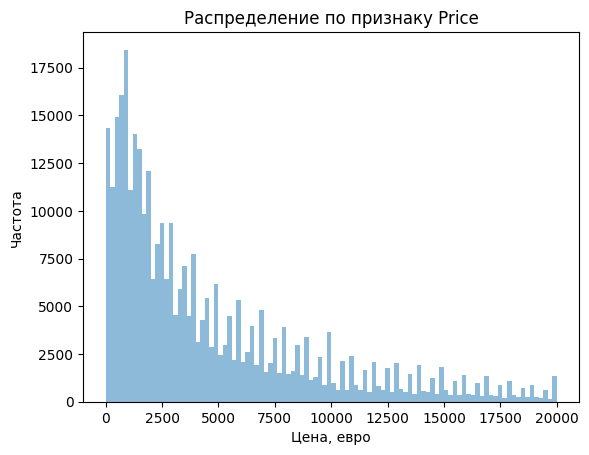

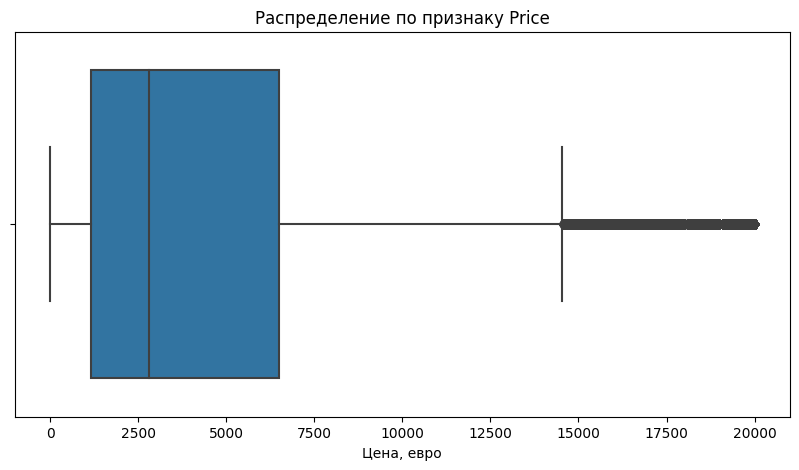

In [12]:
data.Price.plot(kind="hist",
                      title='Распределение по признаку Price',
                      alpha=0.5, 
                      bins=100)
plt.xlabel('Цена, евро')
plt.ylabel('Частота')
plt.show()
plt.figure(figsize=(10, 5))
ax=sns.boxplot(x = data.Price)
ax.set()
plt.xlabel('Цена, евро')
plt.title('Распределение по признаку Price')
plt.show()

Отсеим выбросы с очень низкой (до 200) и очень высокой (более 14800) ценой

In [13]:
data = data[(data['Price']>=200) & (data['Price']<=14800)]

Посмотрим на `Power`

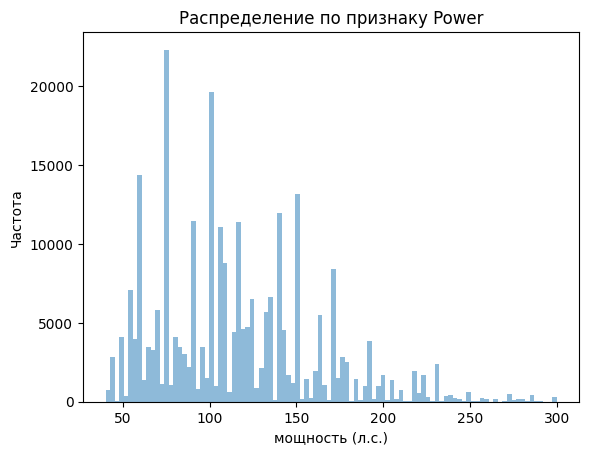

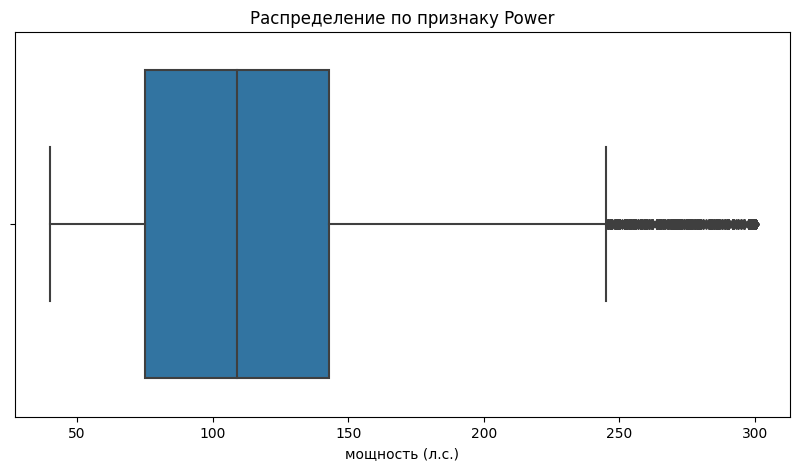

In [14]:
data[(data['Power']>=40) & (data['Power']<=300)].Power.plot(kind="hist",
                      title='Распределение по признаку Power',
                      alpha=0.5, 
                      bins=100)
plt.xlabel('мощность (л.с.)')
plt.ylabel('Частота')
plt.show()
plt.figure(figsize=(10, 5))
ax=sns.boxplot(x = data[(data['Power']>=40) & (data['Power']<=300)].Power)
ax.set()
plt.xlabel('мощность (л.с.)')
plt.title('Распределение по признаку Power')
plt.show()

Отсеим выбросы с очень низкой (до 40) и очень высокой (более 300) мощностью

In [15]:
data = data[(data['Power']>=40) & (data['Power']<=300)]

Посмотрим на `RegistrationYear`

В данных присутствует признак `DateCreated` — дата создания анкеты, отсеим максимальные значения исходя из соображения что год регистрации авто не может быть больше чем дата создания анкеты в сервисе, а минимальные исходя из даты производства первого серийного автомобиля - 1895г

In [16]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d')

data = data[(data['RegistrationYear']>=1895) & (data['RegistrationYear']<=data['DateCreated'].dt.year.max())]

Уберем неинформативные признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `RegistrationMonth` — месяц регистрации автомобиля
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя  

В связи с тем, что они никоим образом не влияют на итоговую стоимость автомобиля и носят информационный характер для сервиса

In [17]:
data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

In [18]:
data.reset_index(drop=True, inplace=True)

Посмотрим на итоговые данные

In [19]:
display(data.describe())
nan_info(data)

,Price,RegistrationYear,Power,Kilometer
count,263219.000000,263219.000000,263219.000000,263219.000000
mean,4198.163438,2002.677326,116.245275,130445.427572
std,3588.051243,6.031581,46.609595,34659.307317
min,200.000000,1910.000000,40.000000,5000.000000
25%,1300.000000,1999.000000,75.000000,125000.000000
50%,2999.000000,2003.000000,109.000000,150000.000000
75%,6200.000000,2007.000000,143.000000,150000.000000
max,14800.000000,2016.000000,300.000000,150000.000000


,Нулевые значения,% значений,Кол-во пропусков,% пропусков
Price,0,0.0,0,0.0
VehicleType,0,0.0,0,0.0
RegistrationYear,0,0.0,0,0.0
Gearbox,0,0.0,0,0.0
Power,0,0.0,0,0.0
Model,0,0.0,0,0.0
Kilometer,0,0.0,0,0.0
FuelType,0,0.0,0,0.0
Brand,0,0.0,0,0.0
Repaired,0,0.0,0,0.0


Данные представлены в 10 столбцах и 263219 строках
В 0 столбцах имеются пропуски в кол-ве 0 или 0.0%


На данном этапе произведена загрузка данных и их подготовка:
- Для анализа данных и построения модели предоставлен датасет, содержащий информацию о технических характеристиках, комплектациях и ценах автомобилей, которые размещались на площадке сервиса «Не бит, не крашен» для продажи. Датасет состоит из 16 столбцов с данными и 354369 строк.
- Пропуски данных были в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`:
    - данные с пропусками в столбце `Model` были удалены;
    - пропуски данных в столбцах `Gearbox` и `FuelType` заполнены ниболее часто встречающимся значением для пары `Brand` - `Model`;
    - пропуски данных в столбцах `VehicleType' заменены на значение `unknown`;
    - пропуски в столбце `Repaired` заменены на `no`.
- Построение диаграмм размаха позволило определить аномальные значения в столбцах `Price` `Power` и избавиться от них;
- Так же обработаны аномалии в `RegistrationYear`
- Финальным этапом предобработки данных стало удаление ненужных для обучения моделей признаков, а именно - `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.

В итоге получен датасет, состоящий из 10 столбцов с данными и 263219 строк.

## Обучение моделей

Подготовим признаки, разделим исходные данные на обучающую и тестовую выборки в соотношении 75:25

In [20]:
# Определим категориальные признаки
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

# Изменим тип, т.к. данные модели градиентного бустинга умеют работать с категориальными признаками
data[cat_features] = data[cat_features].astype('category')

# Подготовим признаки
features = data.drop(['Price'], axis=1)
target = data['Price']

# Разделим данные
(features_train, features_test, 
     target_train, target_test) = train_test_split(features, target, 
                                                     test_size=0.25, 
                                                     random_state=12345)
# Скопируем признаки для кодировки
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

print("Размерность тренеровочных данных", features_train.shape)
print("Размерность тестовых данных", features_test.shape)

Размерность тренеровочных данных (197414, 9)
Размерность тестовых данных (65805, 9)


В данных содержатся категориальные признаки, закодируем их при помощи OrdinalEncoder

In [21]:
# Кодировка OE
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100500)

encoder.fit(features_train[cat_features])

features_train_ohe[cat_features] = pd.DataFrame(encoder.transform(features_train[cat_features]), 
                                                columns=features_train[cat_features].columns,
                                                index=features_train.index)
features_test_ohe[cat_features] = pd.DataFrame(encoder.transform(features_test[cat_features]), 
                                                columns=features_test[cat_features].columns,
                                                index=features_test.index)

Проведем обучение трех моделей: `RandomForestRegressor`, `LGBMRegressor`, `CatBoostRegressor`

Модель на основе Случайного леса

In [22]:
%%time
model_rfr = RandomForestRegressor(random_state=12345)

param_grid_rfr = {
      'n_estimators': range(10, 210, 50),
      'max_depth' : [None] + [i for i in range(2, 11)]
}

# Обучение
cv_rfr = GridSearchCV(estimator=model_rfr, 
                      param_grid=param_grid_rfr, 
                      cv=3,
                      n_jobs=-1,
                      scoring='neg_root_mean_squared_error',
                      verbose=10
                     )
cv_rfr.fit(features_train_ohe, target_train)

cv_rfr_best_params = cv_rfr.best_params_
cv_rfr_best_score = round(-cv_rfr.best_score_, 6)

cv_rfr_results = ['RandomForest', 
                  cv_rfr_best_score, 
                  round(cv_rfr.cv_results_['mean_fit_time'][cv_rfr.best_index_], 6), 
                  round(cv_rfr.cv_results_['mean_score_time'][cv_rfr.best_index_], 6)]

print("best params", cv_rfr_best_params, "score", cv_rfr_best_score)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
best params {'max_depth': None, 'n_estimators': 160} score 1329.22409
CPU times: total: 1min
Wall time: 6min 10s


Модель LightGBM для градиентного бустинга

In [23]:
%%time

model_lgb = LGBMRegressor()

param_grid_lgb = {
    'max_depth': [25, 50],
    'learning_rate' : [0.01, 0.03],
    'n_estimators': range(10, 800, 50),
}

cv_lgb = GridSearchCV(estimator=model_lgb, 
                      param_grid=param_grid_lgb, 
                      cv=3,
                      n_jobs=-1,
                      scoring='neg_root_mean_squared_error',
                      verbose=10
                     )
cv_lgb.fit(features_train, target_train)

cv_lgb_best_params = cv_lgb.best_params_
cv_lgb_best_score = round(-cv_lgb.best_score_, 6)

cv_lgb_results = ['LightGBM', 
                  cv_lgb_best_score, 
                  round(cv_lgb.cv_results_['mean_fit_time'][cv_lgb.best_index_], 6), 
                  round(cv_lgb.cv_results_['mean_score_time'][cv_lgb.best_index_], 6)]

print("best params", cv_lgb_best_params, "score", cv_lgb_best_score)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
best params {'learning_rate': 0.03, 'max_depth': 25, 'n_estimators': 760} score 1287.548695
CPU times: total: 16.5 s
Wall time: 3min 24s


Модель CatBoost для градиентного бустинга

In [24]:
%%time
model_cb = CatBoostRegressor(random_state=12345)

param_grid_cb = {
    'depth' : range(1, 12, 2),
    'iterations': range(10, 300, 50),
}

cv_cb = GridSearchCV(estimator=model_cb, 
                      param_grid=param_grid_cb, 
                      cv=3,
                      n_jobs=-1,
                      scoring='neg_root_mean_squared_error',
                      verbose=10
                     )
cv_cb.fit(features_train, target_train, cat_features=cat_features, verbose=30)

cv_cb_best_params = cv_cb.best_params_
cv_cb_best_score = round(-cv_cb.best_score_, 6)

cv_cb_results = ['CatBoost', 
                  cv_cb_best_score, 
                  round(cv_cb.cv_results_['mean_fit_time'][cv_cb.best_index_], 6), 
                  round(cv_cb.cv_results_['mean_score_time'][cv_cb.best_index_], 6)]

print("best params", cv_cb_best_params, "score", cv_cb_best_score)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Learning rate set to 0.282147
0:	learn: 2883.6270834	total: 306ms	remaining: 1m 19s
30:	learn: 1306.4131369	total: 4.25s	remaining: 31.4s
60:	learn: 1240.0901950	total: 8.12s	remaining: 26.5s
90:	learn: 1195.1667524	total: 12.2s	remaining: 22.7s
120:	learn: 1175.9327643	total: 16.3s	remaining: 18.7s
150:	learn: 1155.2139576	total: 20.1s	remaining: 14.5s
180:	learn: 1139.6349828	total: 24s	remaining: 10.5s
210:	learn: 1123.3033525	total: 28.4s	remaining: 6.61s
240:	learn: 1110.4913573	total: 32.8s	remaining: 2.59s
259:	learn: 1101.7001028	total: 35.7s	remaining: 0us
best params {'depth': 11, 'iterations': 260} score 1277.551066
CPU times: total: 2min 39s
Wall time: 7min 8s


## Анализ моделей

In [25]:
# функция для анализа моделей
def model_analysis (features_train, target_train, features_test, target_test, model, model_name):
    start = time.time()    
    model.fit(features_train, target_train)
    end = time.time()
    fit_time = end - start
    
    start = time.time()
    model_pred = model.predict(features_test)
    end = time.time()
    pred_time = end - start
    
    rmse = round(mean_squared_error(target_test, model_pred, squared = False), 5)
    
    return [model_name, rmse, fit_time, pred_time]

Проведем анализ моделей на:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Сведем полученные в ходе обучения и кросвалидации моделей данные в таблицу

In [29]:
model_analytics = pd.DataFrame([cv_rfr_results, cv_lgb_results, cv_cb_results], 
                        columns =['Модель', 'Качество предсказания (RMSE)', 
                                  'Время обучения модели, сек.', 
                                  'Время предсказания модели, сек'])
model_analytics

,Модель,Качество предсказания (RMSE),"Время обучения модели, сек.","Время предсказания модели, сек"
0,RandomForest,1329.224090,55.981020,5.432731
1,LightGBM,1287.548695,5.706747,4.333320
2,CatBoost,1277.551066,95.597500,0.165333


Исследование проводилось для трех моделей: `RandomForestRegressor`, `LGBMRegressor`, `CatBoostRegressor`.  
В результате при помощи `GridSearchCV` были подобраны оптимальные параметры, проведено обучение моделей а так же проанализирована скорость работы и качество моделей.  
Все модели удовлетворяют заданному условию - Значение метрики RMSE меньше 2500, однако `LGBMRegressor` явлеется безусловным лидером по времени обучения (хотя и проигывает CatBoostRegressor по  предсказаниям), при довольно высоком качестве модели.

Опираясь на требования заказчика, для дальнейшей работы рекомендуем применять модель на основе `LGBMRegressor`.

## Тестирование лучшей модели

Проведем финальное тестирование модели

In [30]:
model_lgb = LGBMRegressor(**cv_lgb_best_params)
model = model_analysis(features_train, target_train, features_test, target_test, model_lgb, 'LightGBM')

print('Модель:', model[0], 
     '\nКачество предсказания (RMSE):', model[1],
     '\nВремя обучения модели:', model[2], ' сек.',
     '\nВремя предсказания модели:', model[3], ' сек.',
     )

Модель: LightGBM 
Качество предсказания (RMSE): 1276.52472 
Время обучения модели: 2.973996877670288  сек. 
Время предсказания модели: 0.8306150436401367  сек.


Полученная модель полностью соответствует требованиям заказчика. Цель достигнута